In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt


from scipy.optimize import broyden1

from edpyt.shared import params
from edpyt.espace import build_espace, screen_espace
from edpyt.gf2_lanczos import build_gf2_lanczos
new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/pentadienyl'
os.chdir(new_path)

/users/ajayaraj/miniconda3/envs/qtpyt/lib/python3.9/site-packages/numba/cpython/hashing.py:524: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


In [ ]:
# === Load inputs ===
input_folder = "output/lowdin"
output_folder = "output/lowdin/beta_1000/ed"
os.makedirs(output_folder, exist_ok=True)

H_eff = np.load(f"{input_folder}/effective_hamiltonian.npy")
occupancy_goal = np.load(f"{input_folder}/beta_1000/occupancies.npy")
V = np.loadtxt(f"{input_folder}/U_matrix.txt")

# === Parameters ===
nimp = H_eff.shape[0]
eta = 1e-3
beta = 1000

# === Initial double counting ===
DC0 = np.diag(V.diagonal() * (occupancy_goal - 0.5))
neig = np.ones((nimp + 1) * (nimp + 1), int) * 6

params["z"] = occupancy_goal

# Precompute reference ratio structure
dc0_diag = DC0.diagonal()

# Initial guess
x0 = dc0_diag.copy()


In [ ]:
class Sigma:
    def __init__(self, gf0, gf, H_eff, eta=1e-5):
        self.gf0 = gf0
        self.gf = gf
        self.eta = eta
        self.H_eff = H_eff

    def retarded(self, energy):
        energies = np.atleast_1d(energy)
        g0 = self.gf0(energies, self.eta)
        g = self.gf(energies, self.eta)
        sigma = np.empty((energies.size, self.gf.n, self.gf.n), complex)
        for e, energy in enumerate(energies):
            sigma[e] = np.linalg.inv(g0[..., e]) - np.linalg.inv(g[..., e])
        return sigma

def residual_function(dc_diag):
    # Clip only the lower bound
    dc_diag = np.clip(dc_diag, 0.0, np.inf)

    DC = np.diag(dc_diag)
    espace, egs = build_espace(H_eff - DC, V, neig_sector=neig)
    screen_espace(espace, egs, beta)
    gf = build_gf2_lanczos(H_eff - DC, V, espace, beta, egs)
    sigma = Sigma( gf, H_eff, eta=eta)

    # Get physical residual from Σ at large negative frequency
    energies = np.array([-1.0])
    sig_cost = sigma.retarded(energies)
    sig_real_diag = sig_cost.real.diagonal(axis1=1, axis2=2)
    residual = np.sum(sig_real_diag, axis=0)

    # Logging
    residual_norm = np.linalg.norm(residual)
    print(f"[Broyden] Residual norm: {residual_norm:.6e}, DC_diag: {dc_diag}")

    return residual

In [15]:
espace, egs = build_espace(H_eff, np.zeros_like(H_eff), neig_sector=neig)
screen_espace(espace, egs, beta)
gf0 = build_gf2_lanczos(H_eff, np.zeros_like(H_eff), espace, beta, egs)

In [ ]:
energy = np.array([-1.0])
gf0_1 = gf0(energy,eta=eta)
gf0_1 = np.array(gf0_1)[:,:,0]
gf0_inv = np.linalg.inv(gf0_1)
gf0_inv

array([[ 3.78852376+1.00000000e-03j, -1.91421496+2.92298498e-17j,
        -0.07734793-4.92932886e-17j, -0.0271844 -1.37020345e-17j,
         0.03608719-1.33265278e-17j,  0.12214289-7.91292874e-18j,
        -0.21345702-5.03084545e-18j],
       [-1.91421496+2.90238356e-17j, -0.39382748+1.00000000e-03j,
        -3.01443925+4.31655799e-17j,  0.1167535 -5.66033351e-18j,
         0.0506806 +3.12470621e-17j, -0.09506318+9.26389841e-18j,
         0.08246743-5.87401180e-18j],
       [-0.07734793-4.95655719e-17j, -3.01443925+4.29350035e-17j,
        -0.82737575+1.00000000e-03j,  2.75190579-4.90937638e-17j,
        -0.05983166+4.36270229e-17j, -0.05195454+4.80016054e-18j,
        -0.03239373-1.80611317e-17j],
       [-0.0271844 -1.37427180e-17j,  0.1167535 -5.45743028e-18j,
         2.75190579-4.93543978e-17j, -1.00316445+1.00000000e-03j,
         2.78327605-1.48607025e-17j, -0.11081976+3.17665893e-17j,
         0.05150389-4.93012217e-17j],
       [ 0.03608719-1.38821233e-17j,  0.0506806 +3.09748

In [35]:
gf_1 = gf(energy,eta=eta)
gf_1 = np.array(gf_1)[:,:,0]
gf_inv = np.linalg.inv(gf_1)
gf_inv

array([[ 3.7884749 +1.01532389e-03j, -2.12605744+3.88961645e-05j,
        -0.2162145 +2.52769841e-06j,  0.02106961+4.61992605e-05j,
         0.06868882-5.43227785e-06j,  0.06249947-3.52046289e-05j,
        -0.23254974-1.59316793e-05j],
       [-2.12605744+3.88961645e-05j, -0.39442507+1.16216798e-03j,
        -3.94116062+8.80078480e-06j,  0.42768896+1.83494485e-04j,
         0.18705867-2.05247903e-05j, -0.37654515-1.40547803e-04j,
        -0.01838446-6.28158920e-05j],
       [-0.2162145 +2.52769841e-06j, -3.94116062+8.80078480e-06j,
        -0.82761675+1.02069766e-03j,  3.51363621+5.10576102e-06j,
        -0.08979733-5.26864549e-06j, -0.22538275+1.91485181e-08j,
        -0.09741978+4.33304047e-07j],
       [ 0.02106961+4.61992605e-05j,  0.42768896+1.83494485e-04j,
         3.51363621+5.10576102e-06j, -1.00312543+1.31194459e-03j,
         3.661596  -2.50912474e-05j, -0.48619441-2.29487294e-04j,
        -0.04597498-1.01588629e-04j],
       [ 0.06868882-5.43227785e-06j,  0.18705867-2.05247

In [30]:
gf0_inv-gf_inv

array([[ 4.88533125e-05-1.53238914e-05j,  2.11842485e-01-3.88961646e-05j,
         1.38866567e-01-2.52769842e-06j, -4.82540126e-02-4.61992605e-05j,
        -3.26016348e-02+5.43227785e-06j,  5.96434214e-02+3.52046289e-05j,
         1.90927111e-02+1.59316793e-05j],
       [ 2.11842485e-01-3.88961646e-05j,  5.97589258e-04-1.62167977e-04j,
         9.26721370e-01-8.80078480e-06j, -3.10935460e-01-1.83494485e-04j,
        -1.36378070e-01+2.05247903e-05j,  2.81481965e-01+1.40547803e-04j,
         1.00851882e-01+6.28158920e-05j],
       [ 1.38866567e-01-2.52769842e-06j,  9.26721370e-01-8.80078480e-06j,
         2.40998652e-04-2.06976622e-05j, -7.61730417e-01-5.10576102e-06j,
         2.99656683e-02+5.26864548e-06j,  1.73428206e-01-1.91485166e-08j,
         6.50260557e-02-4.33304047e-07j],
       [-4.82540126e-02-4.61992605e-05j, -3.10935460e-01-1.83494485e-04j,
        -7.61730417e-01-5.10576102e-06j, -3.90159127e-05-3.11944593e-04j,
        -8.78319951e-01+2.50912474e-05j,  3.75374650e-01+2.2

In [31]:
de = 0.01
energies = np.arange(-3, 3 + de / 2.0, de).round(7)
eta = 1e-3

espace, egs = build_espace(H_eff - DC0, V, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff - DC0, V, espace, beta, egs)
sigma = Sigma(gf, H_eff, eta=3e-2)
sigma_ret = sigma.retarded(energies)
# np.save(f"{output_folder}/sigma_abinit.npy", sigma_ret)


In [ ]:
sigma_ref = np.load("reference/sigma_ed.npy")
np.round(sigma_ref[0],5)

array([[ 0.042  -5.400e-04j, -0.20999+1.410e-03j, -0.14253+7.000e-05j,
        -0.05437-1.750e-03j,  0.03506-2.000e-04j,  0.06826+1.400e-03j,
         0.02516+6.600e-04j],
       [-0.20999+1.410e-03j, -0.14289-5.570e-03j,  0.93223-2.300e-04j,
         0.32793+6.620e-03j, -0.13489+7.500e-04j, -0.29843-5.310e-03j,
        -0.1158 -2.520e-03j],
       [-0.14253+7.000e-05j,  0.93223-2.300e-04j,  0.05644-6.200e-04j,
         0.75422+1.000e-04j,  0.02843+1.600e-04j, -0.16886+4.000e-05j,
        -0.06718+3.000e-05j],
       [-0.05437-1.750e-03j,  0.32793+6.620e-03j,  0.75422+1.000e-04j,
        -0.31032-1.104e-02j,  0.87969-9.600e-04j,  0.40881+8.540e-03j,
         0.11936+4.020e-03j],
       [ 0.03506-2.000e-04j, -0.13489+7.500e-04j,  0.02843+1.600e-04j,
         0.87969-9.600e-04j,  0.06827-8.300e-04j,  1.01447+6.600e-04j,
         0.23074+3.000e-04j],
       [ 0.06826+1.400e-03j, -0.29843-5.310e-03j, -0.16886+4.000e-05j,
         0.40881+8.540e-03j,  1.01447+6.600e-04j, -0.26852-8.830e-03j

In [79]:
dc_diag_optimized = broyden1(
    residual_function,
    x0,
    f_tol=1e-3,
    maxiter=50,
    verbose=True,
)

[Broyden] Residual norm: 2.114902e+00, DC_diag: [5.46515887 1.97886514 2.52035611 2.22202704 2.7152016  2.12250731
 5.90703705]
[Broyden] Residual norm: 2.362296e+00, DC_diag: [3.11307469 3.28217026 4.23748965 3.7732374  4.5134989  3.76731898
 3.80085714]
[Broyden] Residual norm: 2.784512e-01, DC_diag: [4.52254297 2.50117473 3.20851064 2.84368657 3.43588313 2.78167829
 5.06296919]
0:  |F(x)| = 0.151262; step 0.400758
[Broyden] Residual norm: 1.683121e-01, DC_diag: [4.44489596 2.4590732  3.42138892 3.01129126 3.67796451 2.70982219
 4.97293117]
1:  |F(x)| = 0.119863; step 1
[Broyden] Residual norm: 9.861978e-02, DC_diag: [4.41136119 2.55134217 3.33959801 3.01924605 3.56878418 2.86848879
 4.94874025]
2:  |F(x)| = 0.0670133; step 1
[Broyden] Residual norm: 4.094316e-02, DC_diag: [4.3979653  2.52910658 3.36982129 2.96484483 3.61795738 2.80483911
 4.94415642]
3:  |F(x)| = 0.0345809; step 1
[Broyden] Residual norm: 1.963286e-02, DC_diag: [4.41691468 2.5258762  3.36814621 3.00998703 3.60656749

In [32]:
dc_diag_optimized = np.load(f"{output_folder}/ed_dcc_diag_-1ev.npy")
DC = np.diag(dc_diag_optimized)
espace, egs = build_espace(H_eff - DC, V, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff - DC, V, espace, beta, egs)
sigma = Sigma( gf, H_eff, eta=3e-2)
sigma_ret = sigma.retarded(energies)
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)

In [36]:
energy - sigma.H_eff - np.linalg.inv(gf_1)

array([[ 4.88533080e-05-1.01532389e-03j, -7.88157515e-01-3.88961645e-05j,
        -8.61133433e-01-2.52769841e-06j, -1.04825401e+00-4.61992605e-05j,
        -1.03260163e+00+5.43227785e-06j, -9.40356579e-01+3.52046289e-05j,
        -9.80907289e-01+1.59316793e-05j],
       [-7.88157515e-01-3.88961645e-05j,  5.97589228e-04-1.16216798e-03j,
        -7.32786300e-02-8.80078480e-06j, -1.31093546e+00-1.83494485e-04j,
        -1.13637807e+00+2.05247903e-05j, -7.18518035e-01+1.40547803e-04j,
        -8.99148118e-01+6.28158920e-05j],
       [-8.61133433e-01-2.52769841e-06j, -7.32786300e-02-8.80078480e-06j,
         2.40998665e-04-1.02069766e-03j, -1.76173042e+00-5.10576102e-06j,
        -9.70034332e-01+5.26864549e-06j, -8.26571794e-01-1.91485181e-08j,
        -9.34973944e-01-4.33304047e-07j],
       [-1.04825401e+00-4.61992605e-05j, -1.31093546e+00-1.83494485e-04j,
        -1.76173042e+00-5.10576102e-06j, -3.90159539e-05-1.31194459e-03j,
        -1.87831995e+00+2.50912474e-05j, -6.24625350e-01+2.2

In [13]:
sig_ret = sigma.retarded(np.array([-0.5]))
np.round(sigma_ret[0],5)

array([[ 0.04144-3.234e-02j, -2.69526-6.480e-03j, -2.83828-2.270e-03j,
        -3.0086 -4.200e-04j, -3.05753+2.210e-03j, -2.90684-6.920e-03j,
        -2.95929-3.970e-03j],
       [-2.69526-6.480e-03j,  0.34524-5.093e-02j, -2.00019-7.100e-03j,
        -3.14856-1.730e-03j, -3.21918+6.970e-03j, -2.63585-2.154e-02j,
        -2.83878-1.246e-02j],
       [-2.83828-2.270e-03j, -2.00019-7.100e-03j,  0.06819-3.334e-02j,
        -3.76125-6.000e-05j, -3.00093+2.570e-03j, -2.74903-8.290e-03j,
        -2.89105-4.750e-03j],
       [-3.0086 -4.200e-04j, -3.14856-1.730e-03j, -3.76125-6.000e-05j,
         0.35376-3.434e-02j, -3.90962+6.700e-04j, -2.81785+6.000e-04j,
        -2.98169-3.000e-05j],
       [-3.05753+2.210e-03j, -3.21918+6.970e-03j, -3.00093+2.570e-03j,
        -3.90962+6.700e-04j,  0.07893-3.337e-02j, -4.07228+7.730e-03j,
        -3.25982+4.490e-03j],
       [-2.90684-6.920e-03j, -2.63585-2.154e-02j, -2.74903-8.290e-03j,
        -2.81785+6.000e-04j, -4.07228+7.730e-03j,  0.48101-5.845e-02j

In [81]:
energy = [-10000.0]
sig_cost = sigma.retarded(energy)
sig_real_diag = sig_cost.real.diagonal(axis1=1, axis2=2)
print(sig_real_diag)

[[-0.03660698  0.14846752 -0.03802963  0.32163608 -0.05041906  0.25755319
  -0.03842353]]


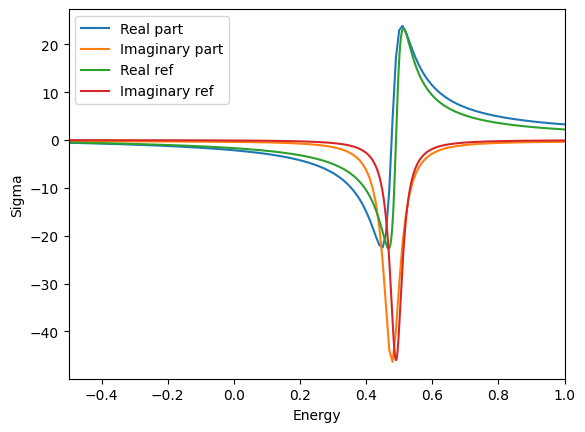

In [86]:
sig_ref = np.load("./reference/sigma_ed_diag.npy")
sig_trace = np.sum(sig_ref, axis=0)
energies_ref = np.linspace(-0.5,1, 2000)

plt.plot(energies, sigma_ret_trace.real, label="Real part")
plt.plot(energies, sigma_ret_trace.imag, label="Imaginary part")
plt.plot(energies_ref,sig_trace.real, label="Real ref")
plt.plot(energies_ref,sig_trace.imag, label="Imaginary ref")
plt.plot
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-0.5, 1)
# plt.ylim(-10,20)
plt.legend()

In [87]:
np.save(f"{output_folder}/ed_dcc_diag_-1ev.npy", dc_diag_optimized)